In [1]:
import numpy as np
import pandas as pd
import plotnine as pn
from rdot import ba_basic, ba_ib, ba_basic, ba_ib
from rdot import distortions

### Hamming

In [2]:
x = np.array([0,1]) # Binary input
xhat = np.array([0,1]) # Binary reconstruction
p = 0.5 # P(X=1) = p
px = np.array([1-p, p])

# distortion matrix
dist_mat = distortions.hamming(*np.meshgrid(x, xhat))        

# Test many values of beta to sweep out a curve. 
betas = np.logspace(-5, 5, num=100)        

rd_values = [result[-2:] for result in ba_basic.ba_iterate(px, dist_mat, betas)]

In [3]:
rd_values[20]

(1.9791947636349505e-07, 0.49973809608575587)

In [4]:
data = pd.DataFrame(rd_values, columns=["rate", "distortion"])
data

,rate,distortion
0,1.803357e-11,0.499998
1,2.871481e-11,0.499997
2,4.572209e-11,0.499996
3,7.280221e-11,0.499995
4,1.159219e-10,0.499994
...,...,...
95,1.000000e+00,0.000000
96,1.000000e+00,0.000000
97,1.000000e+00,0.000000
98,1.000000e+00,0.000000


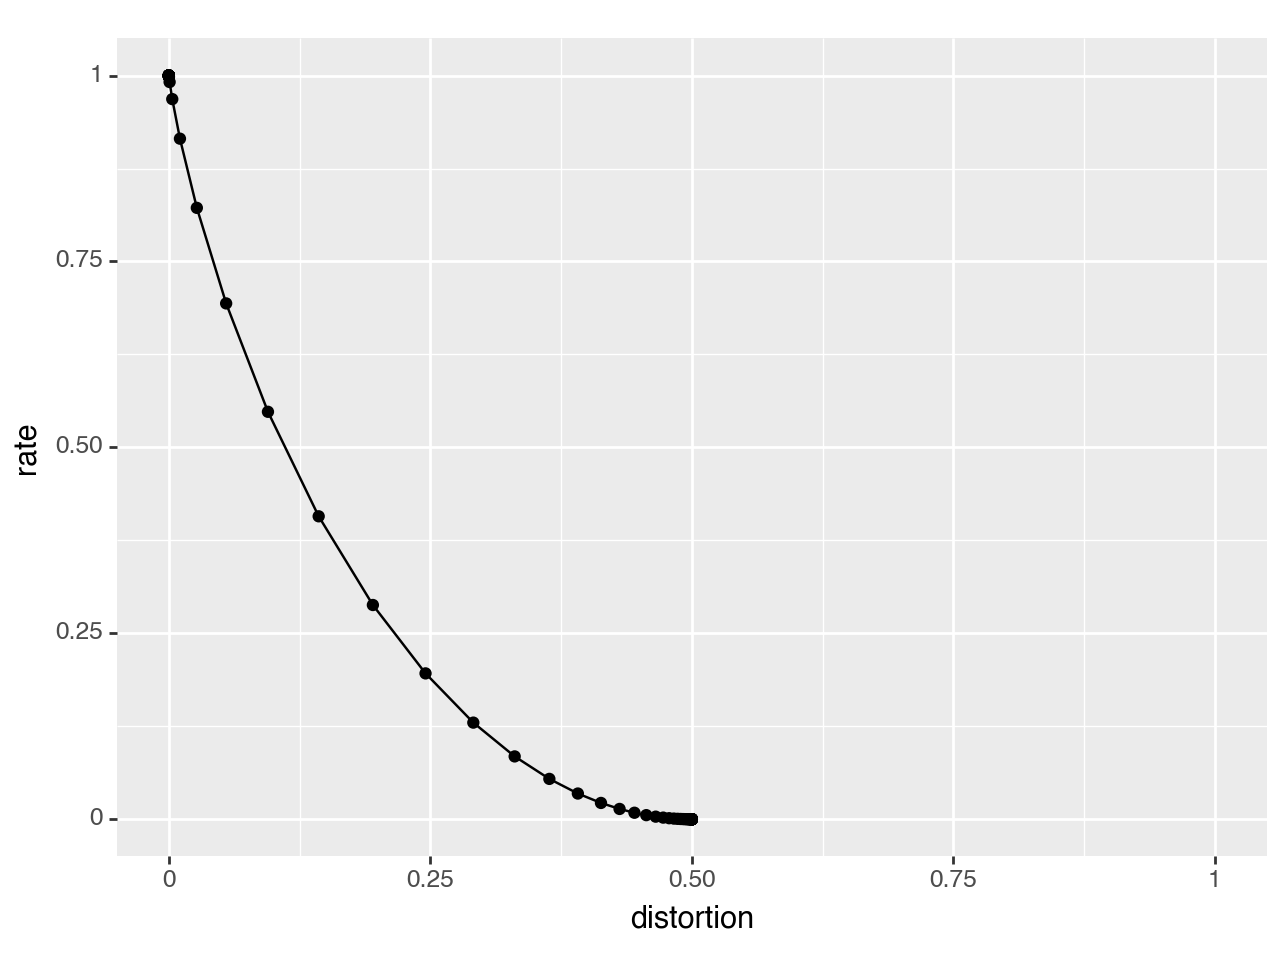

<Figure Size: (640 x 480)>

In [5]:
# Compare to figure 10.4 of Cover and Thomas
(
    pn.ggplot(data, pn.aes(x="distortion", y="rate"))
    + pn.geom_point()
    + pn.geom_line()
    + pn.xlim(0,1)
)

### Gaussian

In [6]:
# (truncated) Gaussian input with quadratic distortion
x = np.linspace(-5,5,1000) # source alphabet
xhat = np.linspace(-5,5,1000) # reconstruction alphabet
px = 1/(2*np.pi) * np.exp(-x ** 2 / 2) # source pdf
px /= px.sum() # guess we actually need this

dist_mat = distortions.quadratic(x, xhat)


# Test many values of beta to sweep out a curve. 
betas = np.logspace(-5, 10, num=100)        

rd_values = [result[-2:] for result in ba_basic.ba_iterate(px, dist_mat, betas)]

In [7]:
data = pd.DataFrame(rd_values, columns=["rate", "distortion"])
data

,rate,distortion
0,2.885159e-10,1.999911
1,5.797069e-10,1.999886
2,1.164764e-09,1.999850
3,2.340240e-09,1.999800
4,4.701956e-09,1.999729
...,...,...
95,8.689497e+00,0.000000
96,8.689497e+00,0.000000
97,8.689497e+00,0.000000
98,8.689497e+00,0.000000


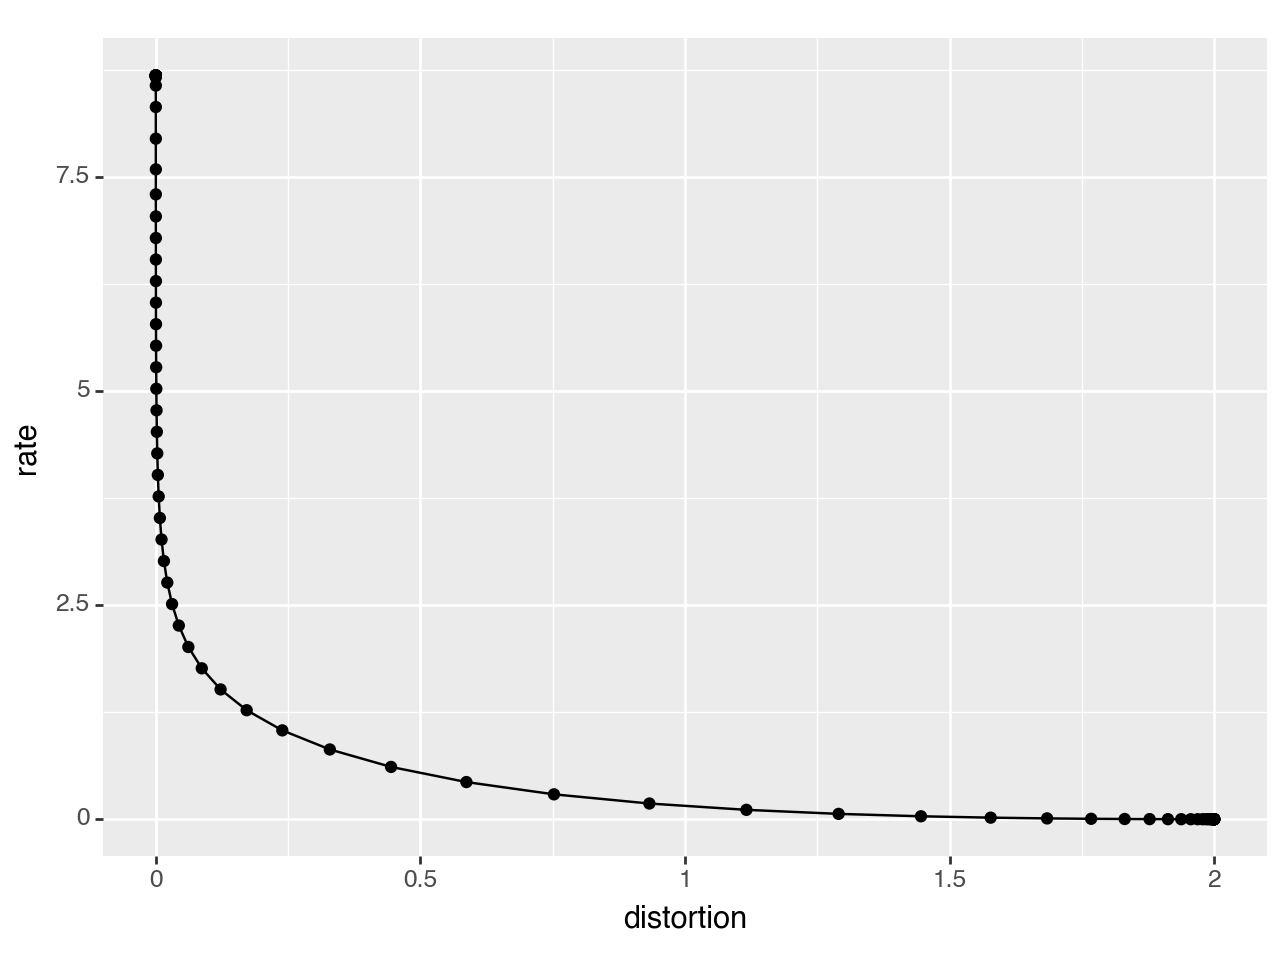

<Figure Size: (640 x 480)>

In [8]:
# Compare to figure 10.4 of Cover and Thomas
(
    pn.ggplot(data, pn.aes(x="distortion", y="rate"))
    + pn.geom_point()
    + pn.geom_line()
)

## IB

In [5]:
# define each p(y|x) to be a gaussian
py_x = np.array([[np.exp(-(i - j)**2) for j in range(10)] for i in range(10)])
py_x /= py_x.sum(axis=1)[:, None]
# get joint by multiplying by p(x)
px = np.full(py_x.shape[0], 1/10)
pxy = py_x * px

# Test many values of beta to sweep out a curve. 
betas = np.logspace(-2, 5, num=1000)
# betas = np.linspace(1e-5, 5, num=100)

rd_values = [
    result[-3:] for result in ba_ib.ib_method(
        pxy, 
        betas,
        num_restarts=1,
    )
]


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/nathanielimel/uci/projects/rdot/src/rdot/ba_ib.py:100: RuntimeWarning: divide by zero encountered in log
100%|██████████| 1000/1000 [01:42<00:00,  9.75it/s]


In [6]:
data = pd.DataFrame(
    rd_values, 
    columns=[
        "rate", 
        "distortion",
        "accuracy",
    ]
)
data

,rate,distortion,accuracy
0,3.321928,-1.466700e-15,1.912028
1,3.321928,-1.466700e-15,1.912028
2,3.321928,-1.466700e-15,1.912028
3,3.321928,-1.466700e-15,1.912028
4,3.321928,-1.466700e-15,1.912028
...,...,...,...
995,0.000000,NaN,0.000000
996,0.000000,NaN,0.000000
997,0.000000,NaN,0.000000
998,0.000000,NaN,0.000000


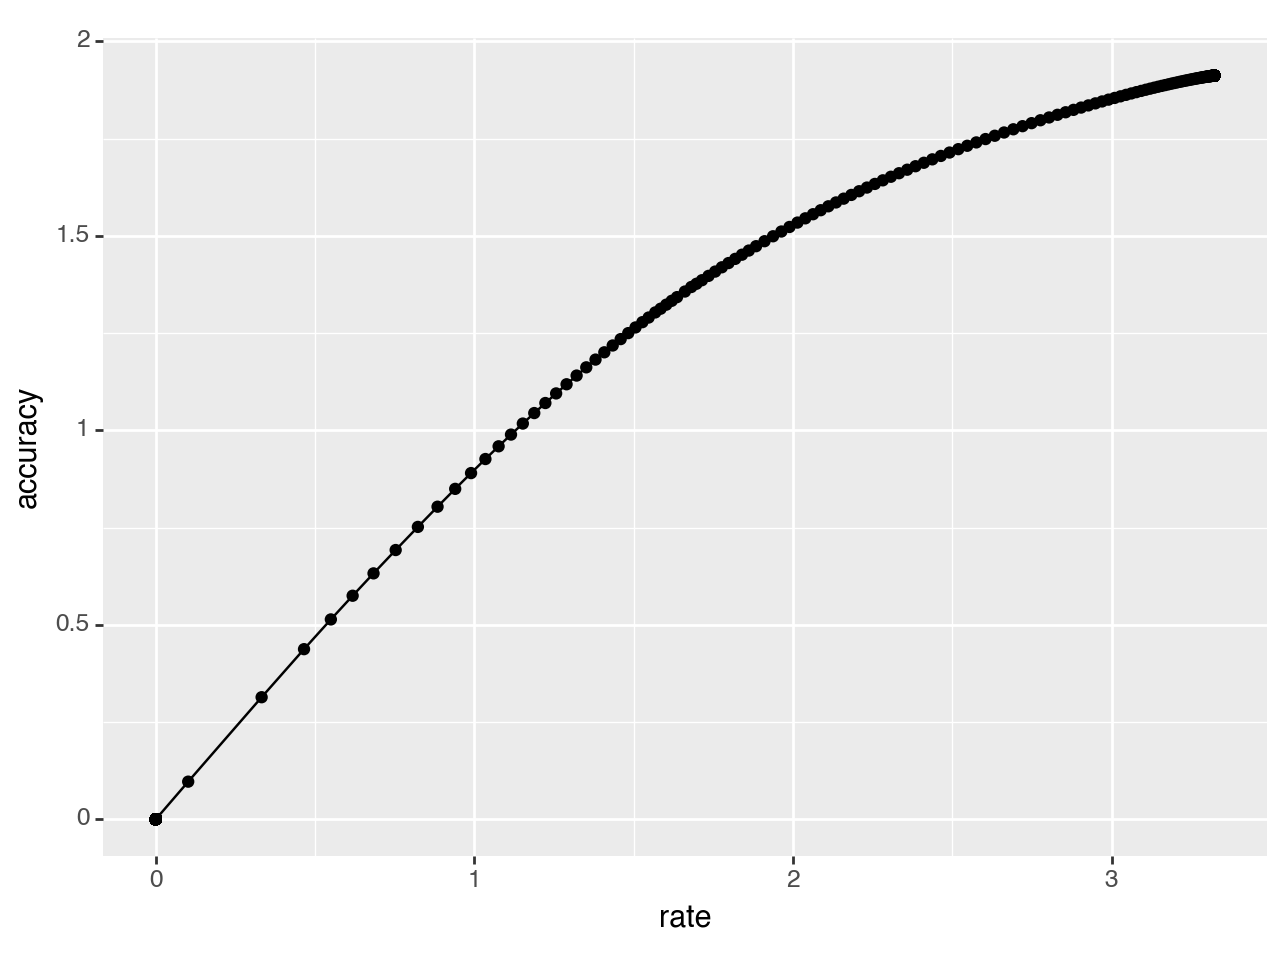

<Figure Size: (640 x 480)>

In [7]:
(
    pn.ggplot(data, pn.aes(x="rate", y="accuracy"))
    + pn.geom_point()
    + pn.geom_line()
)

## Embo validation

In [8]:
from embo import InformationBottleneck

In [9]:
result = InformationBottleneck(
    pxy=pxy,
).get_bottleneck()

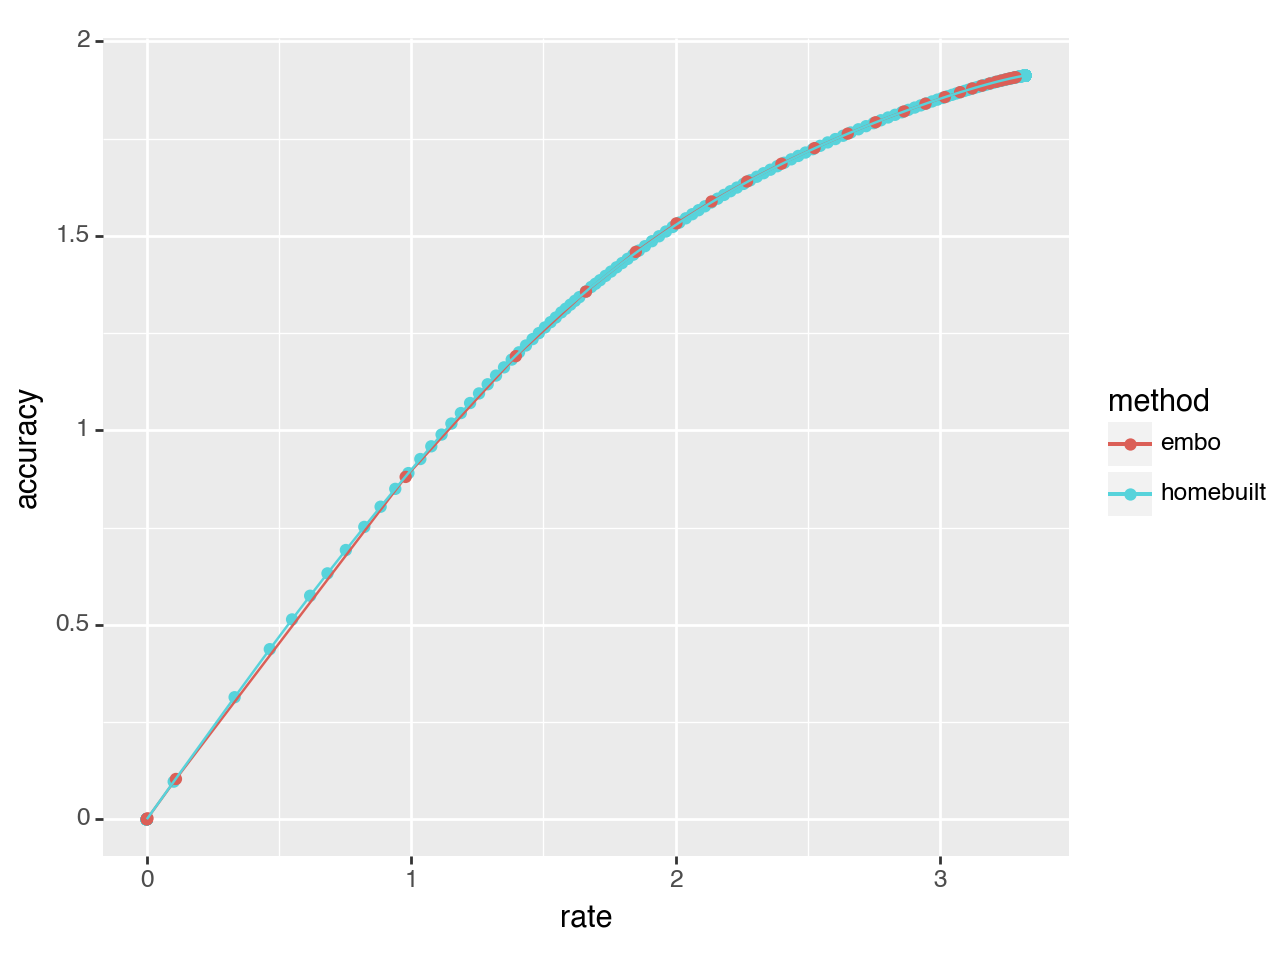

<Figure Size: (640 x 480)>

In [10]:
data["method"] = "homebuilt"
data_embo = pd.DataFrame(zip(*result[0:2]), columns=["rate", "accuracy"])
data_embo["method"] = "embo"
data = pd.concat([data, data_embo])
(
    pn.ggplot(data, pn.aes(x="rate", y="accuracy", color="method"))
    + pn.geom_point()
    + pn.geom_line()    
)

Additional distribution testing

In [18]:
# As noga suggested
py_x = np.array(
    [[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], 
     [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]
).T
py_x /= py_x.sum(axis=1)[:, None]
# get joint by multiplying by p(x)
px = np.full(py_x.shape[0], 1/9)
pxy = py_x * px[:,None]

# Test many values of beta to sweep out a curve. 
betas = np.logspace(-2, 5, num=100)
# betas = np.linspace(1e-5, 5, num=100)

rd_values = [
    result[-3:] for result in ba_ib.ib_method(
        pxy, 
        betas,
        num_restarts=1,
    )
]


100%|██████████| 100/100 [00:01<00:00, 97.17it/s]


In [19]:
data = pd.DataFrame(
    rd_values, 
    columns=[
        "rate", 
        "distortion",
        "accuracy",
    ]
)
data

,rate,distortion,accuracy
0,3.169925e+00,-3.392348e-16,2.126300e-01
1,3.169925e+00,-3.392348e-16,2.126300e-01
2,3.169925e+00,-3.392348e-16,2.126300e-01
3,3.169925e+00,-3.392348e-16,2.126300e-01
4,3.169925e+00,-3.392348e-16,2.126300e-01
...,...,...,...
95,-2.664535e-15,4.487311e-05,-1.998401e-15
96,-2.664535e-15,4.483070e-05,-2.220446e-15
97,-2.220446e-15,4.479470e-05,-1.998401e-15
98,-1.776357e-15,4.476413e-05,-1.998401e-15


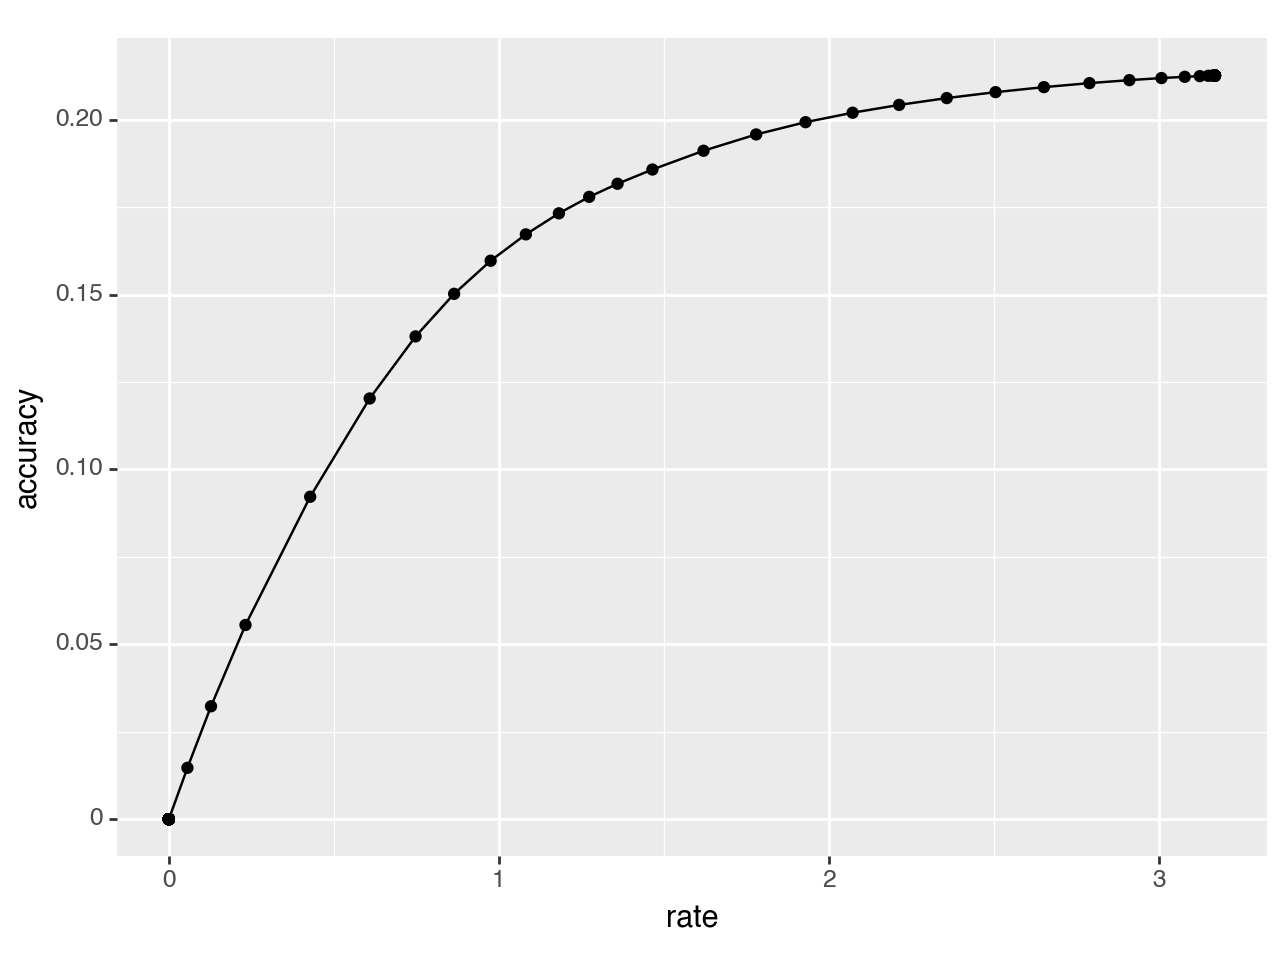

<Figure Size: (640 x 480)>

In [20]:
(
    pn.ggplot(data, pn.aes(x="rate", y="accuracy"))
    + pn.geom_point()
    + pn.geom_line()
)

In [13]:
result = InformationBottleneck(
    pxy=pxy,
).get_bottleneck()

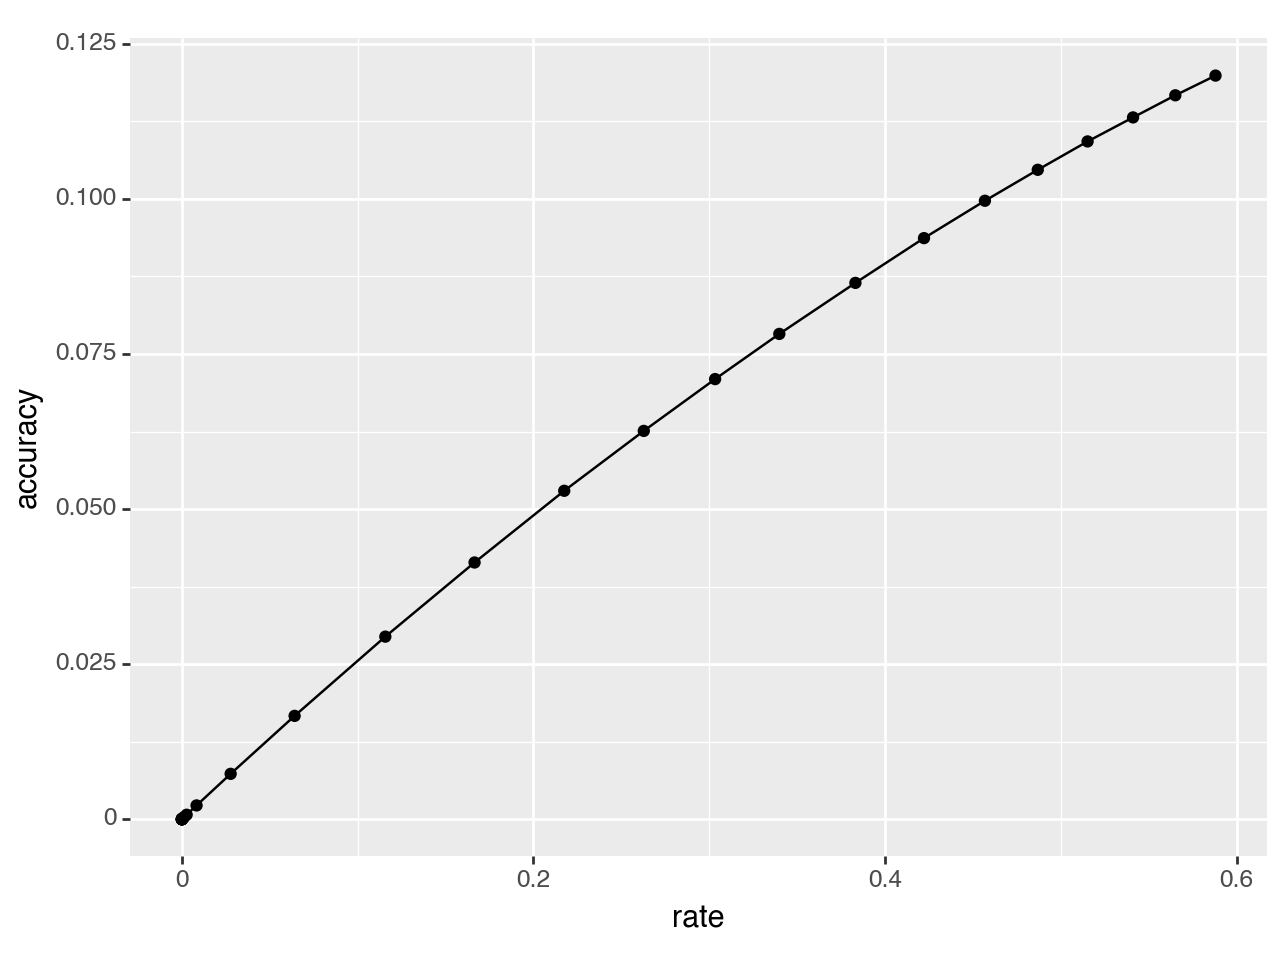

<Figure Size: (640 x 480)>

In [14]:
data["method"] = "homebuilt"
data_embo = pd.DataFrame(zip(*result[0:2]), columns=["rate", "accuracy"])
data_embo["method"] = "embo"
data = pd.concat([data, data_embo])
(
    pn.ggplot(data, pn.aes(x="rate", y="accuracy", color="method"))
    + pn.geom_point()
    + pn.geom_line()    
)